In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
!wget https://github.com/ihpar/ibu_cv/raw/main/cif_10/dataset.zip
!unzip /content/dataset.zip -d cif_10

--2022-05-22 19:52:45--  https://github.com/ihpar/ibu_cv/raw/main/cif_10/dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ihpar/ibu_cv/main/cif_10/dataset.zip [following]
--2022-05-22 19:52:45--  https://raw.githubusercontent.com/ihpar/ibu_cv/main/cif_10/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84986734 (81M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  81.05M   122MB/s    in 0.7s    

2022-05-22 19:52:46 (122 MB/s) - ‘dataset.zip’ saved [84986734/84986734]

Archive:  /content/dataset.zip
  inflating: cif_10/batches.met

In [ ]:
# google colab klasör yolu
CIF_10_KLASORU = "/content/cif_10/"

# lokal klasör yolu
# CIF_10_KLASORU = "../cif_10/"

In [ ]:
def dosya_oku(dosya_yolu):
    with open(dosya_yolu, "rb") as dosya:
        return pickle.load(dosya, encoding="bytes")

In [ ]:
data_batch_1 = dosya_oku(CIF_10_KLASORU + "data_batch_1")
batches_meta = dosya_oku(CIF_10_KLASORU + "batches.meta")

print(data_batch_1.keys())
print(batches_meta.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [ ]:
tum_resimler = data_batch_1[b"data"]
print(tum_resimler.shape)

ilk_resim = tum_resimler[0]
print(ilk_resim.shape)

(10000, 3072)
(3072,)


In [ ]:
def resmi_donustur(resim):
    resim = resim.reshape(3, 32, 32)
    resim = resim.transpose(1, 2, 0)
    return resim

def resmin_sinif_ismi(resim_index):
    sinif_sayisi = data_batch_1[b"labels"][resim_index]
    sinif_ismi = batches_meta[b"label_names"][sinif_sayisi]
    return sinif_ismi.decode("ascii")

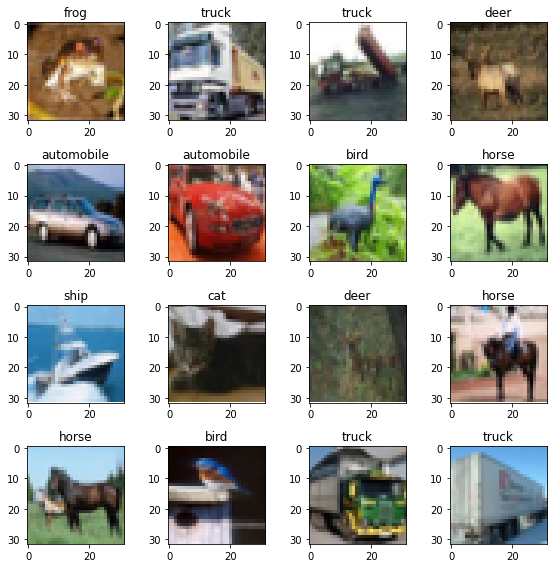

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(resmin_sinif_ismi(i))
    plt.imshow(resmi_donustur(tum_resimler[i]))

plt.tight_layout()
plt.show()

### Problem 
Kedi ve gemi resimlerini ayırt edebilen bir YSA eğitmek.

### İlk aşama
Veri setini hazırlayacağız.
* Veri setinden sadece kedi ve gemi resimlerini alacağız.
* Kedilere 0; gemilere 1 etiketi takacağız.

### İkinci aşama
Çeşitli NN mimarileri oluşturup birbirleri ile karşılaştıracağız.
* Farklı katman sayıları
* Farklı nöron sayıları
* Farklı aktivasyon fonksiyonları

## Veri Seti Hazırlama

In [ ]:
tum_siniflar = np.array(data_batch_1[b"labels"])

print(tum_siniflar[:10])

[6 9 9 4 1 1 2 7 8 3]


In [ ]:
batches_meta[b"label_names"]

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']


* kedinin label indeksi: 3
* gemini label indeksi: 8

In [ ]:
kediler = tum_resimler[tum_siniflar==3] / 255.0
gemiler = tum_resimler[tum_siniflar==8] / 255.0

In [ ]:
print(kediler.shape)
print(gemiler.shape)

(1016, 3072)
(1025, 3072)


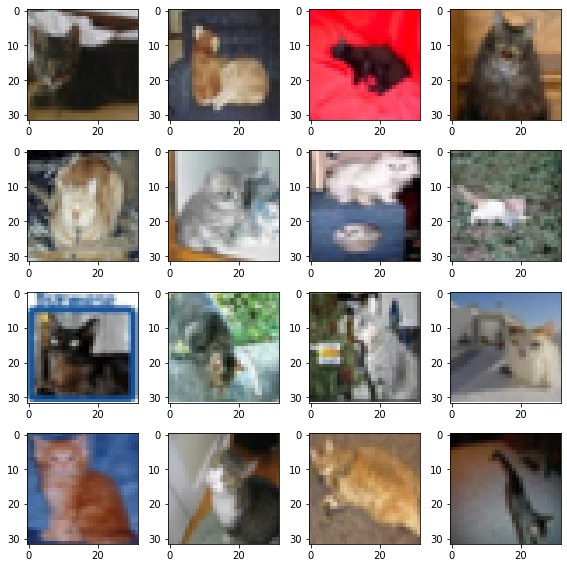

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(resmi_donustur(kediler[i]))

plt.tight_layout()
plt.show()

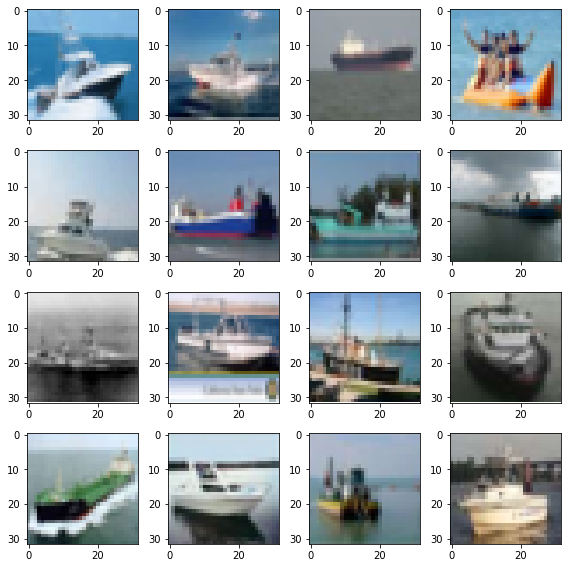

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(resmi_donustur(gemiler[i]))

plt.tight_layout()
plt.show()

In [ ]:
kedi_sayisi = kediler.shape[0]
gemi_sayisi = gemiler.shape[0]
print(kedi_sayisi, gemi_sayisi)

1016 1025


In [ ]:
y_kedi = np.zeros(kedi_sayisi)
y_gemi = np.ones(gemi_sayisi)
print(y_kedi.shape, y_gemi.shape)

(1016,) (1025,)


In [ ]:
X = np.concatenate((kediler, gemiler), axis=0)
print(X.shape)

y = np.concatenate((y_kedi, y_gemi), axis=0)
print(y.shape)

(2041, 3072)
(2041,)


In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

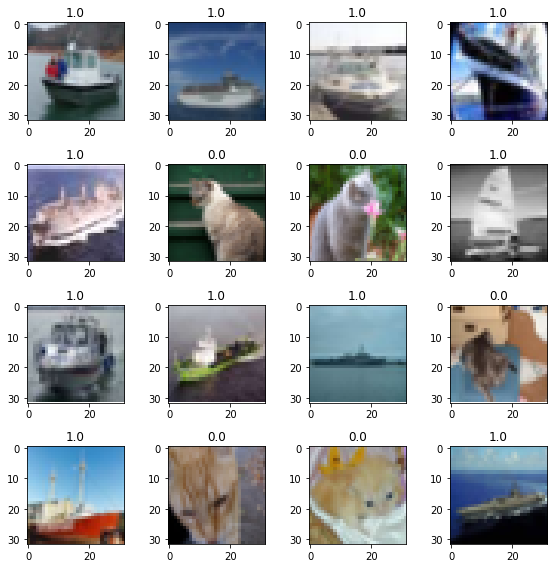

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(resmi_donustur(X_train[i]))

plt.tight_layout()
plt.show()

## NN Mimarileri ve Testler

### Model 0: Tek katman, tek nöron, aktivasyon sigmoid

In [ ]:
model_0 = Sequential()
model_0.add(Dense(1, input_shape=(3072,)))
model_0.add(Activation("sigmoid"))

model_0.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3073      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_0.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)

Epoch 1/20
51/51 [==============================] - 1s 6ms/step - loss: 0.8466 - accuracy: 0.7145 - val_loss: 0.4379 - val_accuracy: 0.8078
Epoch 2/20
51/51 [==============================] - 0s 3ms/step - loss: 0.4717 - accuracy: 0.8064 - val_loss: 0.4502 - val_accuracy: 0.8059
Epoch 3/20
51/51 [==============================] - 0s 3ms/step - loss: 0.4442 - accuracy: 0.8076 - val_loss: 0.4895 - val_accuracy: 0.7990
Epoch 4/20
51/51 [==============================] - 0s 3ms/step - loss: 0.5211 - accuracy: 0.7996 - val_loss: 0.3608 - val_accuracy: 0.8647
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3711 - accuracy: 0.8529 - val_loss: 0.3366 - val_accuracy: 0.8637
Epoch 6/20
51/51 [==============================] - 0s 3ms/step - loss: 0.4121 - accuracy: 0.8309 - val_loss: 0.4358 - val_accuracy: 0.8245
Epoch 7/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3576 - accuracy: 0.8523 - val_loss: 0.4954 - val_accuracy: 0.7941
Epoch 8/20
51/51 [==

In [ ]:
print("Model 0 degerlendirmesi:")
model_0.evaluate(X_test, y_test)

Model 0 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 0.8795


[0.2927800714969635, 0.8795298933982849]

In [ ]:
def plot_model_history(history): 
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model 0 Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

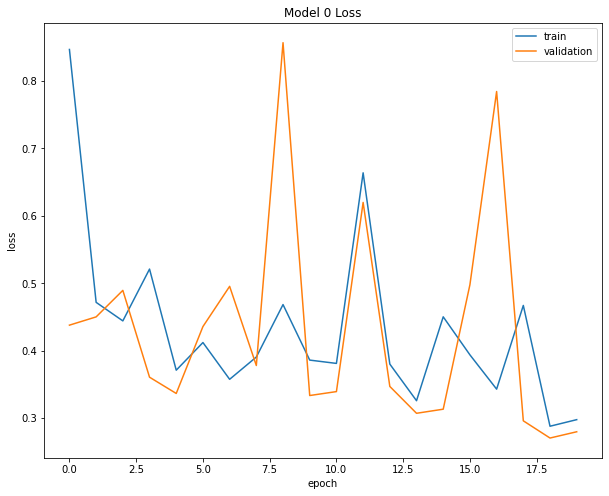

In [ ]:
plot_model_history(history)

In [ ]:
def plot_model_tahminleri(model, X_test, y_test):
    plt.figure(figsize=(9, 9))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        prediction = model.predict([X_test[i].reshape(-1, 3072)])
        prediction = np.round(prediction[0][0], 2)
        plt.title("Gercek:" + str(y_test[i]) + ", tahmin:" + str(prediction))
        plt.imshow(resmi_donustur(X_test[i]))

    plt.tight_layout()
    plt.show()

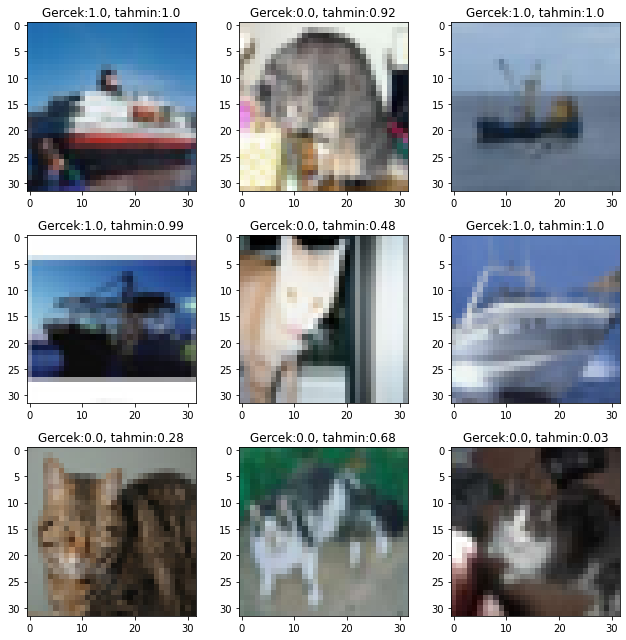

In [ ]:
plot_model_tahminleri(model_0, X_test, y_test)

### Model 1: İlk katman 32 nöron, çıkış 1 nöron, aktivasyon sigmoid

In [ ]:
model_1 = Sequential()
model_1.add(Dense(32, activation="linear", input_shape=(3072,)))
model_1.add((Dense(1, activation="sigmoid")))

model_1.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                98336     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 98,369
Trainable params: 98,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
51/51 [==============================] - 1s 7ms/step - loss: 2.2982 - accuracy: 0.7157 - val_loss: 0.4404 - val_accuracy: 0.8069
Epoch 2/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4034 - accuracy: 0.8272 - val_loss: 0.3960 - val_accuracy: 0.8324
Epoch 3/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3753 - accuracy: 0.8395 - val_loss: 0.3740 - val_accuracy: 0.8451
Epoch 4/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3666 - accuracy: 0.8536 - val_loss: 0.4256 - val_accuracy: 0.8176
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3768 - accuracy: 0.8438 - val_loss: 0.3739 - val_accuracy: 0.8578
Epoch 6/20
51/51 [==============================] - 0s 6ms/step - loss: 0.3704 - accuracy: 0.8407 - val_loss: 0.3734 - val_accuracy: 0.8480
Epoch 7/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3607 - accuracy: 0.8517 - val_loss: 0.3640 - val_accuracy: 0.8431
Epoch 8/20
51/51 [==

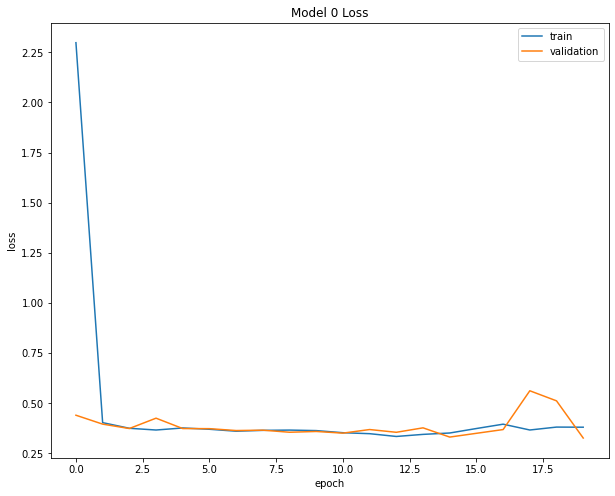

Model 1 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8727


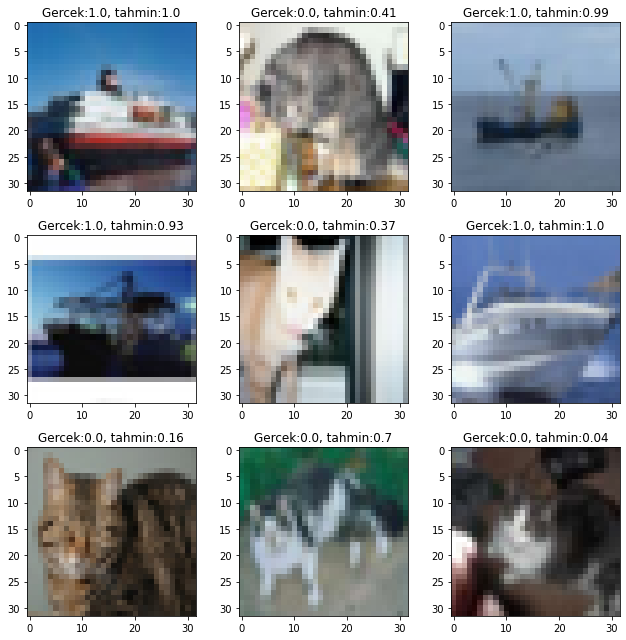

In [ ]:
history_1 = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
plot_model_history(history_1)

print("Model 1 degerlendirmesi:")
model_1.evaluate(X_test, y_test)

plot_model_tahminleri(model_1, X_test, y_test)

### Model 2: İlk katman 32 nöron - aktivaston relu, çıkış 1 nöron, aktivasyon sigmoid

In [ ]:
model_2 = Sequential()
model_2.add(Dense(32, activation="relu", input_shape=(3072,)))
model_2.add((Dense(1, activation="sigmoid")))

model_2.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                98336     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 98,369
Trainable params: 98,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
51/51 [==============================] - 1s 8ms/step - loss: 1.3822 - accuracy: 0.7077 - val_loss: 0.4341 - val_accuracy: 0.8020
Epoch 2/20
51/51 [==============================] - 0s 5ms/step - loss: 0.4003 - accuracy: 0.8186 - val_loss: 0.3684 - val_accuracy: 0.8451
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4158 - accuracy: 0.8150 - val_loss: 0.3589 - val_accuracy: 0.8480
Epoch 4/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3771 - accuracy: 0.8370 - val_loss: 0.5009 - val_accuracy: 0.7775
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4223 - accuracy: 0.8199 - val_loss: 0.5480 - val_accuracy: 0.7490
Epoch 6/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3737 - accuracy: 0.8382 - val_loss: 0.3386 - val_accuracy: 0.8627
Epoch 7/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3383 - accuracy: 0.8597 - val_loss: 0.3247 - val_accuracy: 0.8627
Epoch 8/20
51/51 [==

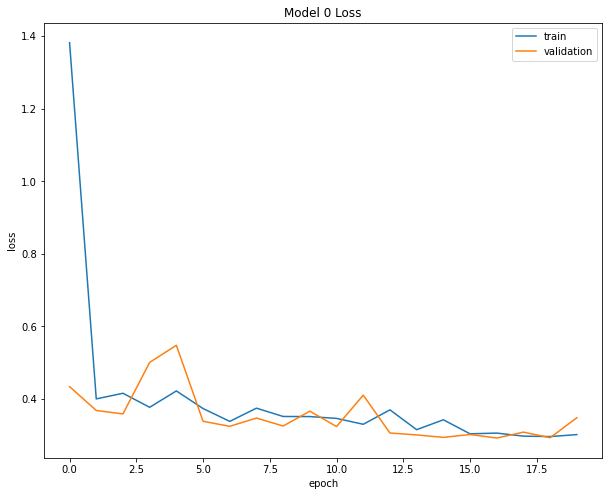

Model 2 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.3394 - accuracy: 0.8492


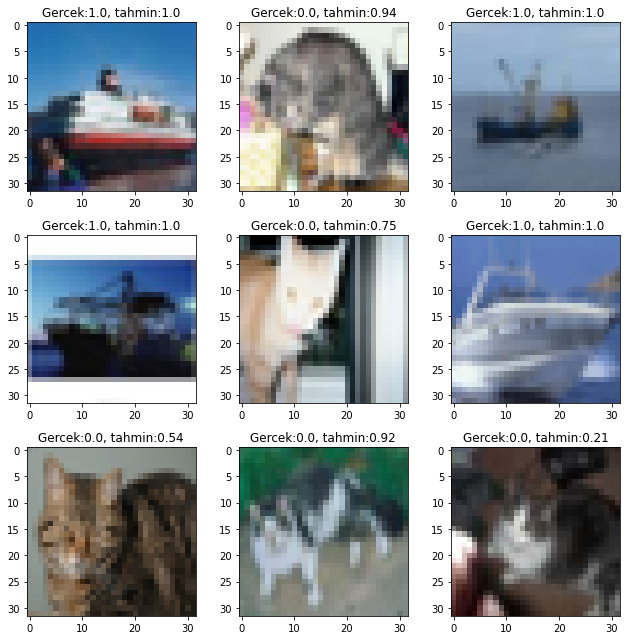

In [ ]:
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
plot_model_history(history_2)

print("Model 2 degerlendirmesi:")
model_2.evaluate(X_test, y_test)

plot_model_tahminleri(model_2, X_test, y_test)

### Model 3: İlk katman 8 nöron - aktivaston relu, ikinci katman 4 nöron - aktivasyon relu, çıkış 1 nöron, aktivasyon sigmoid

In [ ]:
model_3 = Sequential()
model_3.add(Dense(8, activation="relu", input_shape=(3072,)))
model_3.add(Dense(4, activation="relu"))
model_3.add((Dense(1, activation="sigmoid")))

model_3.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 24584     
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 24,625
Trainable params: 24,625
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
51/51 [==============================] - 1s 12ms/step - loss: 0.7759 - accuracy: 0.5852 - val_loss: 0.6495 - val_accuracy: 0.6020
Epoch 2/20
51/51 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6054 - val_loss: 0.6993 - val_accuracy: 0.5108
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5172 - val_loss: 0.6830 - val_accuracy: 0.5461
Epoch 4/20
51/51 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6949 - val_loss: 0.5454 - val_accuracy: 0.7892
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5365 - accuracy: 0.7684 - val_loss: 0.5122 - val_accuracy: 0.7912
Epoch 6/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4890 - accuracy: 0.8088 - val_loss: 0.4769 - val_accuracy: 0.8118
Epoch 7/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.8229 - val_loss: 0.4426 - val_accuracy: 0.8304
Epoch 8/20
51/51 [=

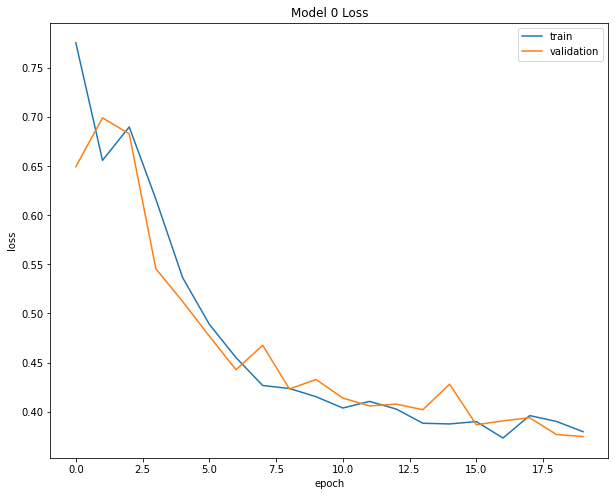

Model 3 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.8639


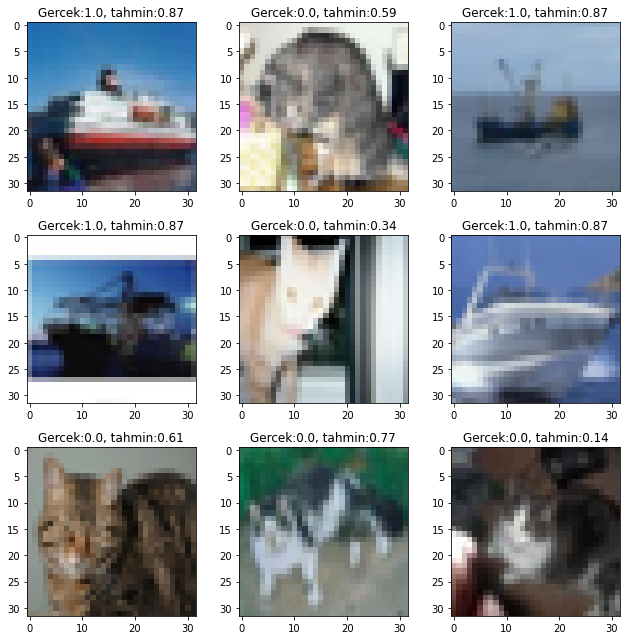

In [ ]:
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
plot_model_history(history_3)

print("Model 3 degerlendirmesi:")
model_3.evaluate(X_test, y_test)

plot_model_tahminleri(model_3, X_test, y_test)

### Model 4: İlk katman 64 nöron - aktivaston linear, ikinci katman 64 nöron - aktivasyon relu, çıkış 1 nöron, aktivasyon sigmoid, validasyon setinde iyileşme durunca eğitim erken bitecek

In [ ]:
model_4 = Sequential()
model_4.add(Dense(64, activation="linear", input_shape=(3072,)))
model_4.add(Dense(64, activation="relu"))
model_4.add((Dense(1, activation="sigmoid")))

model_4.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                196672    
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 200,897
Trainable params: 200,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

Epoch 1/50
102/102 [==============================] - 2s 9ms/step - loss: 2.6376 - accuracy: 0.6740 - val_loss: 1.3326 - val_accuracy: 0.6500
Epoch 2/50
102/102 [==============================] - 0s 5ms/step - loss: 0.5609 - accuracy: 0.7843 - val_loss: 0.4467 - val_accuracy: 0.8186
Epoch 3/50
102/102 [==============================] - 0s 4ms/step - loss: 0.4332 - accuracy: 0.8137 - val_loss: 0.3469 - val_accuracy: 0.8637
Epoch 4/50
102/102 [==============================] - 0s 5ms/step - loss: 0.4090 - accuracy: 0.8156 - val_loss: 0.3384 - val_accuracy: 0.8520
Epoch 5/50
102/102 [==============================] - 0s 5ms/step - loss: 0.3917 - accuracy: 0.8333 - val_loss: 0.3708 - val_accuracy: 0.8500
Epoch 6/50
102/102 [==============================] - 0s 5ms/step - loss: 0.4514 - accuracy: 0.8143 - val_loss: 0.4696 - val_accuracy: 0.7961
Epoch 7/50
102/102 [==============================] - 0s 5ms/step - loss: 0.3842 - accuracy: 0.8290 - val_loss: 0.3480 - val_accuracy: 0.8588
Epoch 

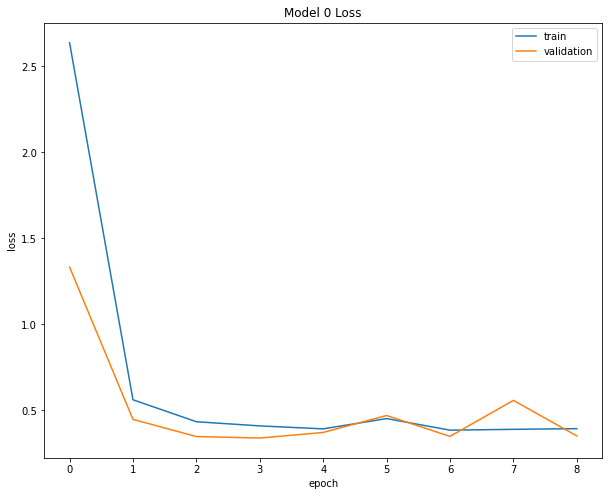

Model 4 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.3355 - accuracy: 0.8590


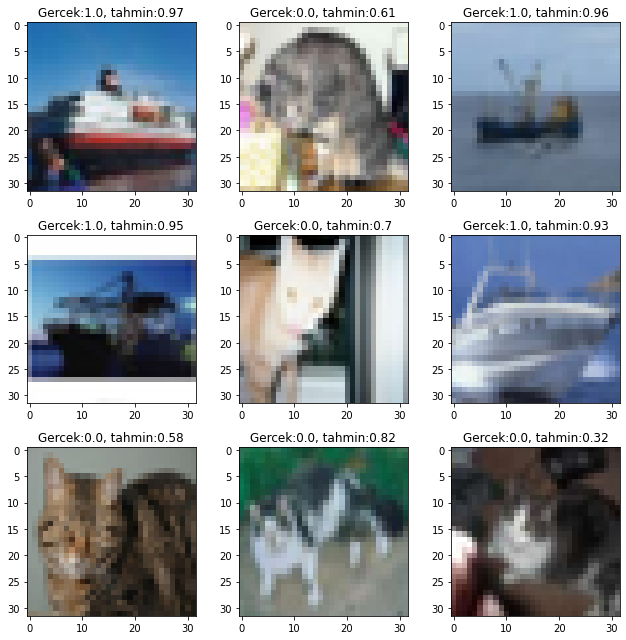

In [ ]:
history_4 = model_4.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50, callbacks=[es_callback])

plot_model_history(history_4)

print("Model 4 degerlendirmesi:")
model_4.evaluate(X_test, y_test)

plot_model_tahminleri(model_4, X_test, y_test)

# ***YSA Cifar 10 - Sınıflandırma Ödevi***


Ebubekir GÜLEN 181906078 

Problem: Geyik ve At resimlerini ayırt edebilen bir YSA eğitmek.

İlk aşama: Veri setini hazırlayacağız.

Veri setinden sadece geyik ve at resimlerini alacağız.
Geyiklere 0; At 1 etiketi takacağız.

İkinci aşama: Model 3 kullanacağız.

In [ ]:
geyikler = tum_resimler[tum_siniflar==4] / 255.0
atlar = tum_resimler[tum_siniflar==7] / 255.0

In [ ]:
print(geyikler.shape)
print(atlar.shape)

(999, 3072)
(1001, 3072)


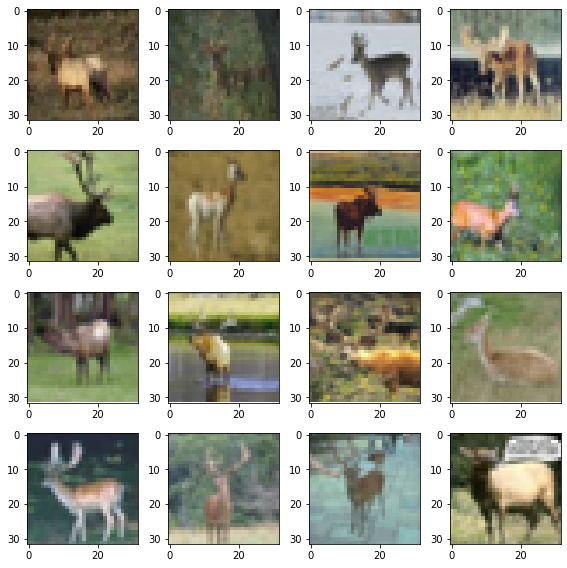

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(resmi_donustur(geyikler[i]))

plt.tight_layout()
plt.show() 


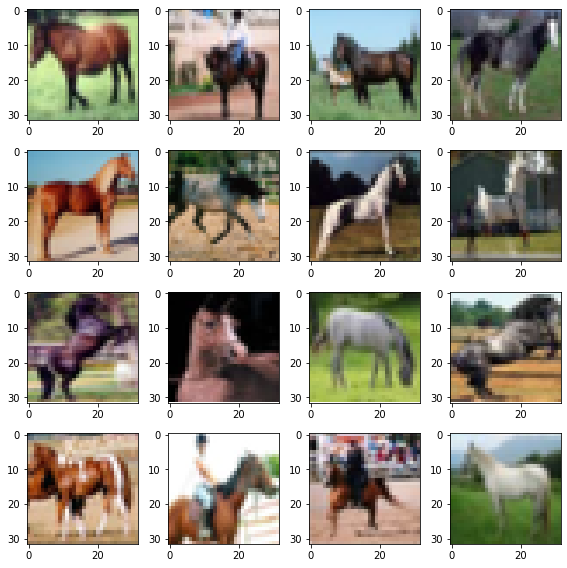

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(resmi_donustur(atlar[i]))

plt.tight_layout()
plt.show() 


In [ ]:
geyik_sayisi = geyikler.shape[0]
at_sayisi = atlar.shape[0]
print(kedi_sayisi, gemi_sayisi)

1016 1025


In [ ]:
y_geyik = np.zeros(geyik_sayisi)
y_at = np.ones(at_sayisi)
print(y_geyik.shape, y_at.shape)

(999,) (1001,)


In [ ]:
X = np.concatenate((geyikler, atlar), axis=0)
print(X.shape)

y = np.concatenate((y_geyik, y_at), axis=0)
print(y.shape)

(2000, 3072)
(2000,)


In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

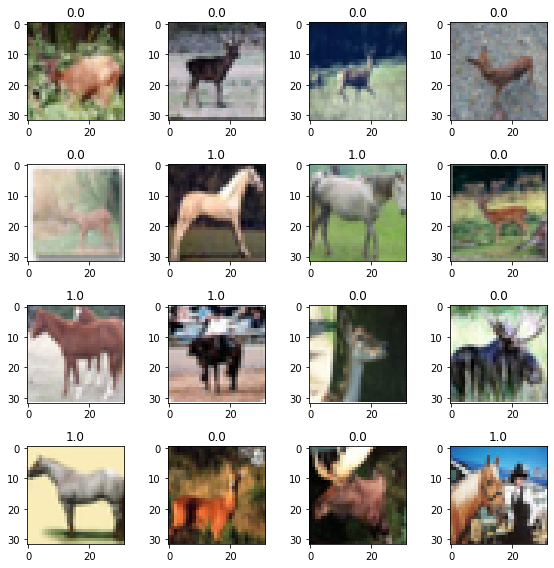

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(resmi_donustur(X_train[i]))

plt.tight_layout()
plt.show()

Model 3'e eklenerek yapılmıştır : İlk katman 64 nöron - aktivasyon relu, ikinci katman 64 nöron - aktivasyon relu, üçüncü katman 16 nöron - aktivasyon linear, üçüncü katman 16 nöron - aktivasyon linear, çıkış 1 nöron, aktivasyon sigmoid. Yüzde 80 başarının üstünü sağlamıştır zip dosyamdaki fotoğrafta da görebilirsiniz.

In [ ]:
model_3 = Sequential()
model_3.add(Dense(64, activation="relu", input_shape=(3072,)))
model_3.add(Dense(32, activation="relu"))
model_3.add(Dense(16, activation="linear"))
model_3.add(Dense(16, activation="linear"))
model_3.add((Dense(1, activation="sigmoid")))

model_3.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
model_3.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_163 (Dense)           (None, 64)                196672    
                                                                 
 dense_164 (Dense)           (None, 16)                1040      
                                                                 
 dense_165 (Dense)           (None, 32)                544       
                                                                 
 dense_166 (Dense)           (None, 16)                528       
                                                                 
 dense_167 (Dense)           (None, 1)                 17        
                                                                 
Total params: 198,801
Trainable params: 198,801
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2958 - accuracy: 0.8813 - val_loss: 0.2318 - val_accuracy: 0.9120
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2265 - accuracy: 0.9125 - val_loss: 0.2246 - val_accuracy: 0.9130
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2725 - accuracy: 0.8875 - val_loss: 0.2295 - val_accuracy: 0.9060
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2326 - accuracy: 0.9125 - val_loss: 0.2258 - val_accuracy: 0.9090
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2456 - accuracy: 0.9062 - val_loss: 0.2428 - val_accuracy: 0.9010
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.2182 - accuracy: 0.9169 - val_loss: 0.3222 - val_accuracy: 0.8750
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2507 - accuracy: 0.8981 - val_loss: 0.2600 - val_accuracy: 0.8920
Epoch 8/20
50/50 [==

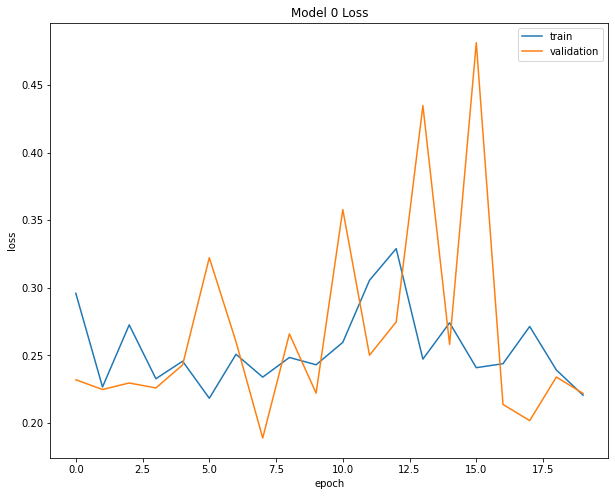

Model 3 degerlendirmesi:
32/32 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8640


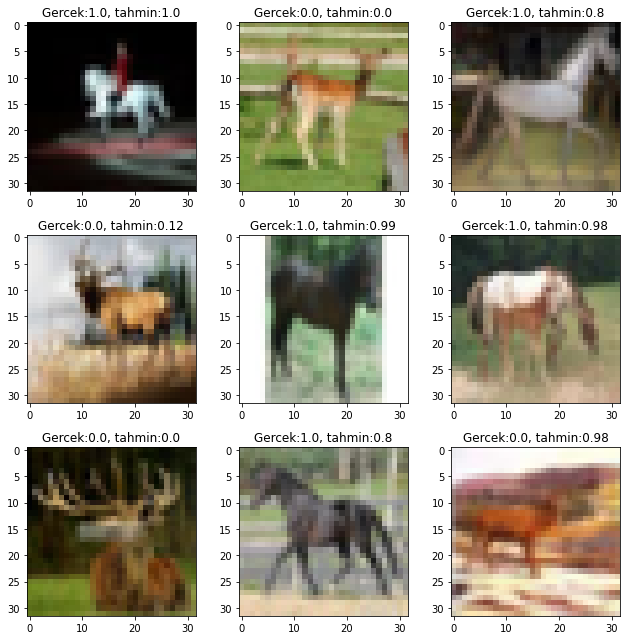

In [ ]:
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
plot_model_history(history_3)

print("Model 3 degerlendirmesi:")
model_3.evaluate(X_test, y_test)

plot_model_tahminleri(model_3, X_test, y_test)